In [3]:
#@title Code - Load dependencies

#general
import io

# data
import numpy as np
import pandas as pd

# machine learning
import keras

# data visualization
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

In [4]:
chicago_taxi_dataset = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/chicago_taxi_train.csv")

In [5]:
# Updates dataframe to use specific columns.
training_df = chicago_taxi_dataset[['TRIP_MILES', 'TRIP_SECONDS', 'FARE', 'COMPANY', 'PAYMENT_TYPE', 'TIP_RATE']]

print('Read dataset completed successfully.')
print('Total number of rows: {0}\n\n'.format(len(training_df.index)))
training_df.head(200)

Read dataset completed successfully.
Total number of rows: 31694




,TRIP_MILES,TRIP_SECONDS,FARE,COMPANY,PAYMENT_TYPE,TIP_RATE
0,2.57,2341,31.99,Flash Cab,Mobile,6.3
1,1.18,1074,9.75,Flash Cab,Credit Card,27.9
2,1.29,1173,10.25,Sun Taxi,Cash,0.0
3,3.70,3360,23.75,Choice Taxi Association,Cash,0.0
4,1.15,1044,10.00,Flash Cab,Cash,0.0
...,...,...,...,...,...,...
195,1.13,821,9.00,Blue Ribbon Taxi Association,Mobile,22.9
196,0.57,414,6.00,Flash Cab,Cash,0.0
197,1.22,886,9.00,City Service,Cash,0.0
198,1.68,1219,9.00,Sun Taxi,Mobile,23.0


In [6]:
print('Total number of rows: {0}\n\n'.format(len(training_df.index)))
training_df.describe(include='all')

Total number of rows: 31694




,TRIP_MILES,TRIP_SECONDS,FARE,COMPANY,PAYMENT_TYPE,TIP_RATE
count,31694.000000,31694.000000,31694.000000,31694,31694,31694.000000
unique,NaN,NaN,NaN,31,7,NaN
top,NaN,NaN,NaN,Flash Cab,Credit Card,NaN
freq,NaN,NaN,NaN,7887,14142,NaN
mean,8.289463,1319.796397,23.905210,NaN,NaN,12.965785
std,7.265672,928.932873,16.970022,NaN,NaN,15.517765
min,0.500000,60.000000,3.250000,NaN,NaN,0.000000
25%,1.720000,548.000000,9.000000,NaN,NaN,0.000000
50%,5.920000,1081.000000,18.750000,NaN,NaN,12.200000
75%,14.500000,1888.000000,38.750000,NaN,NaN,20.800000


In [7]:
corr_matrix = training_df.corr(numeric_only=True)
print(corr_matrix)

              TRIP_MILES  TRIP_SECONDS      FARE  TIP_RATE
TRIP_MILES      1.000000      0.800855  0.975344 -0.049594
TRIP_SECONDS    0.800855      1.000000  0.830292 -0.084294
FARE            0.975344      0.830292  1.000000 -0.070979
TIP_RATE       -0.049594     -0.084294 -0.070979  1.000000


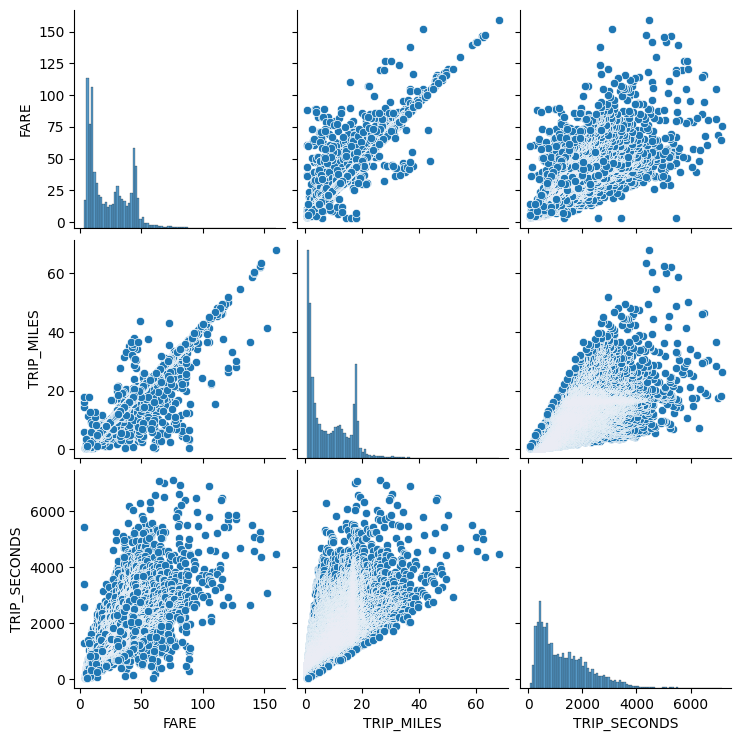

In [9]:
sns.pairplot(training_df, x_vars=["FARE", "TRIP_MILES", "TRIP_SECONDS"], y_vars=["FARE", "TRIP_MILES", "TRIP_SECONDS"])

In [13]:
#@title Define plotting functions

def make_plots(df, feature_names, label_name, model_output, sample_size=200):

  random_sample = df.sample(n=sample_size).copy()
  random_sample.reset_index()
  weights, bias, epochs, rmse = model_output

  is_2d_plot = len(feature_names) == 1
  model_plot_type = "scatter" if is_2d_plot else "surface"
  fig = make_subplots(rows=1, cols=2,
                      subplot_titles=("Loss Curve", "Model Plot"),
                      specs=[[{"type": "scatter"}, {"type": model_plot_type}]])

  plot_data(random_sample, feature_names, label_name, fig)
  plot_model(random_sample, feature_names, weights, bias, fig)
  plot_loss_curve(epochs, rmse, fig)

  fig.show()
  return

def plot_loss_curve(epochs, rmse, fig):
  curve = px.line(x=epochs, y=rmse)
  curve.update_traces(line_color='#ff0000', line_width=3)

  fig.append_trace(curve.data[0], row=1, col=1)
  fig.update_xaxes(title_text="Epoch", row=1, col=1)
  fig.update_yaxes(title_text="Root Mean Squared Error", row=1, col=1, range=[rmse.min()*0.8, rmse.max()])

  return

def plot_data(df, features, label, fig):
  if len(features) == 1:
    scatter = px.scatter(df, x=features[0], y=label)
  else:
    scatter = px.scatter_3d(df, x=features[0], y=features[1], z=label)

  fig.append_trace(scatter.data[0], row=1, col=2)
  if len(features) == 1:
    fig.update_xaxes(title_text=features[0], row=1, col=2)
    fig.update_yaxes(title_text=label, row=1, col=2)
  else:
    fig.update_layout(scene1=dict(xaxis_title=features[0], yaxis_title=features[1], zaxis_title=label))

  return

def plot_model(df, features, weights, bias, fig):
  df['FARE_PREDICTED'] = bias[0]

  for index, feature in enumerate(features):
    df['FARE_PREDICTED'] = df['FARE_PREDICTED'] + weights[index][0] * df[feature]

  if len(features) == 1:
    model = px.line(df, x=features[0], y='FARE_PREDICTED')
    model.update_traces(line_color='#ff0000', line_width=3)
  else:
    z_name, y_name = "FARE_PREDICTED", features[1]
    z = [df[z_name].min(), (df[z_name].max() - df[z_name].min()) / 2, df[z_name].max()]
    y = [df[y_name].min(), (df[y_name].max() - df[y_name].min()) / 2, df[y_name].max()]
    x = []
    for i in range(len(y)):
      x.append((z[i] - weights[1][0] * y[i] - bias[0]) / weights[0][0])

    plane=pd.DataFrame({'x':x, 'y':y, 'z':[z] * 3})

    light_yellow = [[0, '#89CFF0'], [1, '#FFDB58']]
    model = go.Figure(data=go.Surface(x=plane['x'], y=plane['y'], z=plane['z'],
                                      colorscale=light_yellow))

  fig.add_trace(model.data[0], row=1, col=2)

  return

def model_info(feature_names, label_name, model_output):
  weights = model_output[0]
  bias = model_output[1]

  nl = "\n"
  header = "-" * 80
  banner = header + nl + "|" + "MODEL INFO".center(78) + "|" + nl + header

  info = ""
  equation = label_name + " = "

  for index, feature in enumerate(feature_names):
    info = info + "Weight for feature[{}]: {:.3f}\n".format(feature, weights[index][0])
    equation = equation + "{:.3f} * {} + ".format(weights[index][0], feature)

  info = info + "Bias: {:.3f}\n".format(bias[0])
  equation = equation + "{:.3f}\n".format(bias[0])

  return banner + nl + info + nl + equation

print("SUCCESS: defining plotting functions complete.")

SUCCESS: defining plotting functions complete.


In [14]:
#@title Code - Define ML functions

def build_model(my_learning_rate, num_features):
  """Create and compile a simple linear regression model."""
  # Describe the topography of the model.
  # The topography of a simple linear regression model
  # is a single node in a single layer.
  inputs = keras.Input(shape=(num_features,))
  outputs = keras.layers.Dense(units=1)(inputs)
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile the model topography into code that Keras can efficiently
  # execute. Configure training to minimize the model's mean squared error.
  model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=[keras.metrics.RootMeanSquaredError()])

  return model


def train_model(model, features, label, epochs, batch_size):
  """Train the model by feeding it data."""

  # Feed the model the feature and the label.
  # The model will train for the specified number of epochs.
  history = model.fit(x=features,
                      y=label,
                      batch_size=batch_size,
                      epochs=epochs)

  # Gather the trained model's weight and bias.
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the error for each epoch.
  hist = pd.DataFrame(history.history)

  # To track the progression of training, we're going to take a snapshot
  # of the model's root mean squared error at each epoch.
  rmse = hist["root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse


def run_experiment(df, feature_names, label_name, learning_rate, epochs, batch_size):

  print('INFO: starting training experiment with features={} and label={}\n'.format(feature_names, label_name))

  num_features = len(feature_names)

  features = df.loc[:, feature_names].values
  label = df[label_name].values

  model = build_model(learning_rate, num_features)
  model_output = train_model(model, features, label, epochs, batch_size)

  print('\nSUCCESS: training experiment complete\n')
  print('{}'.format(model_info(feature_names, label_name, model_output)))
  make_plots(df, feature_names, label_name, model_output)

  return model

print("SUCCESS: defining linear regression functions complete.")

SUCCESS: defining linear regression functions complete.


In [15]:
#@title Code - Experiment 1

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 50

# Specify the feature and the label.
features = ['TRIP_MILES']
label = 'FARE'

model_1 = run_experiment(training_df, features, label, learning_rate, epochs, batch_size)

INFO: starting training experiment with features=['TRIP_MILES'] and label=FARE

Epoch 1/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 384.9194 - root_mean_squared_error: 19.5936
Epoch 2/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 159.6887 - root_mean_squared_error: 12.6014
Epoch 3/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 40.6116 - root_mean_squared_error: 6.3449
Epoch 4/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 17.4104 - root_mean_squared_error: 4.1668
Epoch 5/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 16.8651 - root_mean_squared_error: 4.1037  
Epoch 6/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step - loss: 15.9209 - root_mean_squared_error: 3.9855
Epoch 7/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step - loss: 14.2035 - root_mean_squared_error: 3.7601
Epoch 8/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step - loss: 14.0855 - root_mean_squared_error: 3.7497
Epoch 9/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 13.4471 - root_mean_squared_erro

In [16]:
# The following variables are the hyperparameters.
# TODO - Adjust these hyperparameters to see how they impact a training run.
learning_rate = 0.001
epochs = 20
batch_size = 50

# Specify the feature and the label.
features = ['TRIP_MILES']
label = 'FARE'

model_1 = run_experiment(training_df, features, label, learning_rate, epochs, batch_size)

INFO: starting training experiment with features=['TRIP_MILES'] and label=FARE

Epoch 1/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - loss: 1305.6339 - root_mean_squared_error: 36.1166
Epoch 2/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 849.2794 - root_mean_squared_error: 29.1066
Epoch 3/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 470.3495 - root_mean_squared_error: 21.6669
Epoch 4/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 214.4641 - root_mean_squared_error: 14.6093
Epoch 5/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 61.7214 - root_mean_squared_error: 7.8207
Epoch 6/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 15.2573 - root_mean_squared_error: 3.8912
Epoch 7/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 14.4492 - root_mean_squared_error: 3.7958
Epoch 8/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 15.8265 - root_mean_squared_error: 3.9654
Epoch 9/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 13.8915 - root_mean_squared_error

In [17]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 50

training_df.loc[:, 'TRIP_MINUTES'] = training_df['TRIP_SECONDS']/60

features = ['TRIP_MILES', 'TRIP_MINUTES']
label = 'FARE'

model_2 = run_experiment(training_df, features, label, learning_rate, epochs, batch_size)

INFO: starting training experiment with features=['TRIP_MILES', 'TRIP_MINUTES'] and label=FARE

Epoch 1/20


C:\Users\ramirred\AppData\Local\Temp\ipykernel_25264\316932342.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 957us/step - loss: 22.6937 - root_mean_squared_error: 4.7601
Epoch 2/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step - loss: 16.1774 - root_mean_squared_error: 4.0192
Epoch 3/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 953us/step - loss: 13.5773 - root_mean_squared_error: 3.6768
Epoch 4/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 14.6052 - root_mean_squared_error: 3.8182
Epoch 5/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 12.8439 - root_mean_squared_error: 3.5737
Epoch 6/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13.0978 - root_mean_squared_error: 3.6085
Epoch 7/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10.9871 - root_mean_squared_error: 3.3043
Epoch 8/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11.9336 - root_mean_squared_error: 3.4512
Epoch 9/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12.3411 - root_mean_squared_error: 3.5024
Epoch 10/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12.9829 - root_mean_square

In [18]:
#@title Code - Define functions to make predictions
def format_currency(x):
  return "${:.2f}".format(x)

def build_batch(df, batch_size):
  batch = df.sample(n=batch_size).copy()
  batch.set_index(np.arange(batch_size), inplace=True)
  return batch

def predict_fare(model, df, features, label, batch_size=50):
  batch = build_batch(df, batch_size)
  predicted_values = model.predict_on_batch(x=batch.loc[:, features].values)

  data = {"PREDICTED_FARE": [], "OBSERVED_FARE": [], "L1_LOSS": [],
          features[0]: [], features[1]: []}
  for i in range(batch_size):
    predicted = predicted_values[i][0]
    observed = batch.at[i, label]
    data["PREDICTED_FARE"].append(format_currency(predicted))
    data["OBSERVED_FARE"].append(format_currency(observed))
    data["L1_LOSS"].append(format_currency(abs(observed - predicted)))
    data[features[0]].append(batch.at[i, features[0]])
    data[features[1]].append("{:.2f}".format(batch.at[i, features[1]]))

  output_df = pd.DataFrame(data)
  return output_df

def show_predictions(output):
  header = "-" * 80
  banner = header + "\n" + "|" + "PREDICTIONS".center(78) + "|" + "\n" + header
  print(banner)
  print(output)
  return

In [19]:
#@title Code - Make predictions

output = predict_fare(model_2, training_df, features, label)
show_predictions(output)

--------------------------------------------------------------------------------
|                                 PREDICTIONS                                  |
--------------------------------------------------------------------------------
   PREDICTED_FARE OBSERVED_FARE L1_LOSS  TRIP_MILES TRIP_MINUTES
0          $23.42        $22.75   $0.67        7.94        22.90
1          $12.30        $11.75   $0.55        3.20        13.00
2          $44.73        $44.25   $0.48       17.60        34.00
3          $47.22        $46.00   $1.22       18.10        43.80
4           $8.24         $7.50   $0.74        1.72         6.02
5          $49.08        $46.25   $2.83       18.70        48.00
6          $21.44        $20.29   $1.15        7.60        14.28
7          $26.87        $26.75   $0.12        9.87        19.70
8          $43.42        $42.50   $0.92       17.13        31.62
9          $12.83        $12.25   $0.58        3.36        14.37
10         $25.25        $24.50   $0.75   